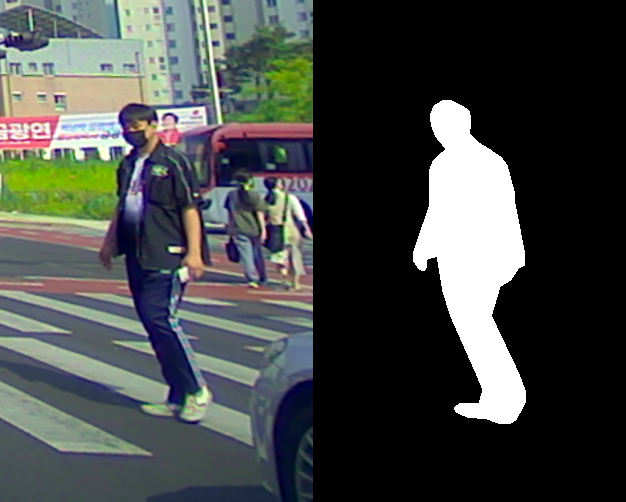

In [79]:
from PIL import Image

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid

image_path = '/data/noah/inference/magna_human_premask/images/3.png'
mask_path = '/data/noah/inference/magna_human_premask/masks/3.png'

image = Image.open(image_path)
mask = Image.open(mask_path)

grid = make_grid([image,mask], 1, 2)
display(grid)

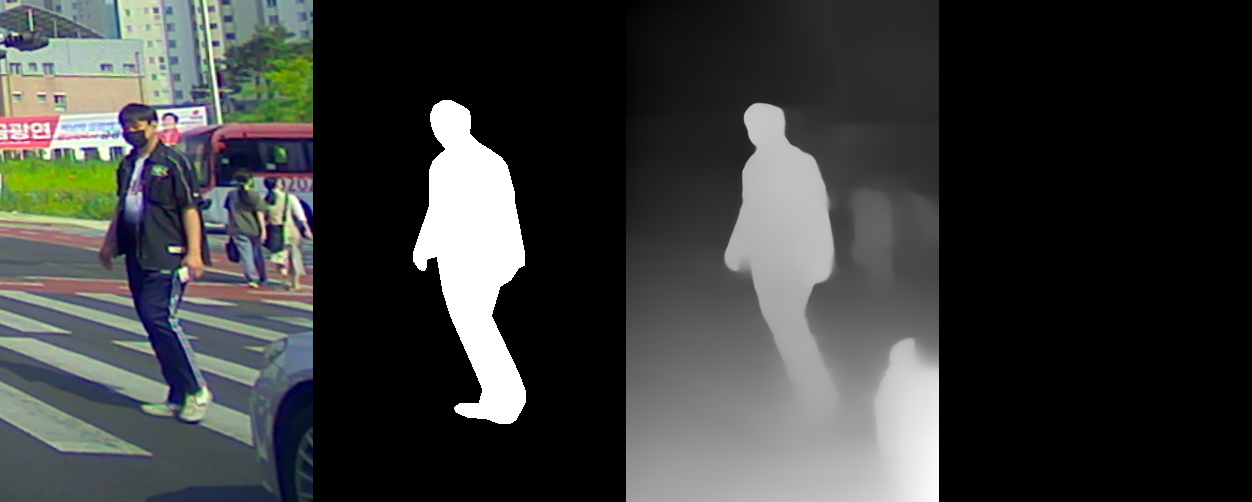

In [80]:
from controlnet_aux.processor import MidasDetector

device = 'cuda:3'
midas = MidasDetector.from_pretrained("lllyasviel/Annotators").to(device)
con_image = midas(image, image_resolution=image.height)
con_image = con_image.resize((image.width, image.height))

grid = make_grid([grid, con_image], 1, 2)
display(grid)

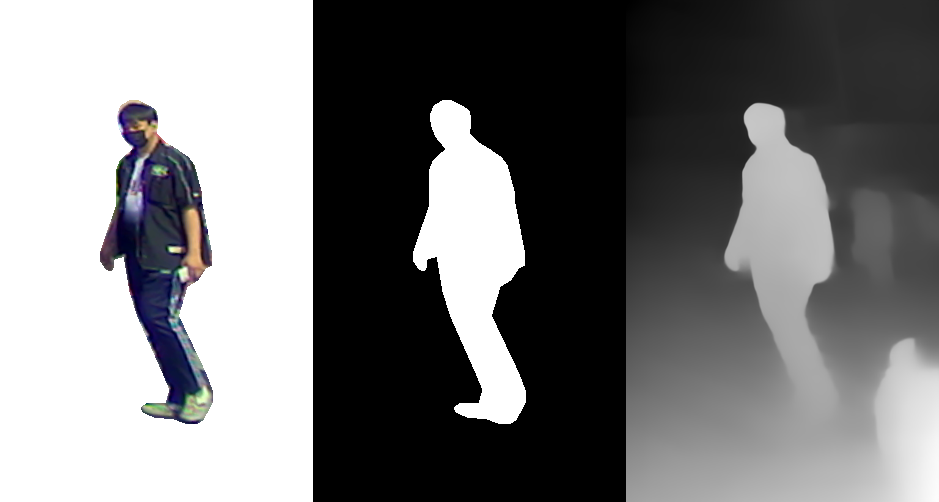

In [81]:
import numpy as np
from PIL import Image
from IPython.display import display

spots = np.argwhere(np.array(mask) == 255)
masked_image = np.ones((mask.height, mask.width, 3))*255
image = np.array(image)

for spot in spots:
    masked_image[spot[0], spot[1], :] = image[spot[0], spot[1], :]

masked_image = Image.fromarray(masked_image.astype('uint8'))

grid = make_grid([masked_image, mask, con_image], rows=1, cols=3)
display(grid)

In [64]:
def closest_multiple_of_8(number):
    closest_multiple = (number // 8) * 8  # 가장 가까운 8의 배수
    return closest_multiple

height, width = closest_multiple_of_8(int(masked_image.height*1.0)), closest_multiple_of_8(int(masked_image.width*1.0))

masked_image = masked_image.resize((width, height))
mask = mask.resize((width,height))
con_image = con_image.resize((width, height))

In [65]:
import cv2
import torch
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, DDIMScheduler

model_id = "/data/noah/ckpt/pretrain_ckpt/StableDiffusion/rv_inpaint_5.1"
controlnet_id = "/data/noah/ckpt/finetuning/controlnet_inpaint_coco_rider/checkpoint-21000/controlnet"
lora_id = "/data/noah/ckpt/pretrain_ckpt/StableDiffusion/lora_detail"

controlnet = ControlNetModel.from_pretrained(controlnet_id, torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    model_id, controlnet=controlnet, torch_dtype=torch.float16
).to(device)
pipe.load_lora_weights(lora_id, weight_name="add_detail.safetensors")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_freeu(s1=1.2, s2=0.5, b1=1.2, b2=1.4)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/workspace/aimmo-synthetic/src/diffusers/loaders/lora.py:805: FutureWarning: `_modify_text_encoder` is deprecated and will be removed in version 0.27. You are using an old version of LoRA backend. This will be deprecated in the next releases in favor of PEFT make sure to install the latest PEFT and transformers packages in the future.
  deprecate("_modify_text_encoder", "0.27", LORA_DEPRECATION_MESSAGE)
/workspace/aimmo-synthetic/src/diffusers/loaders/lora.py:777: FutureWarning: `_remove_text_encoder_monkey_patch_classmethod` is deprecated and will be removed in version 0.27. You are using an old version of LoRA backend. This will be deprecated in the next releases in favor of PEFT make sure to install the latest PEFT and transf

In [66]:
prompt = "a person, RAW photo, subject, 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3, <lora:add-detail:1>"
negative_prompt = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime), blurry, text, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, UnrealisticDream"
num_inference_steps = 40
guidance_scale = 7.5
strength = 1.0
sag_scale = 0.75
controlnet_conditioning_scale = 0.5

result_image = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            image=image,
            control_image=con_image,
            mask_image=mask,
            height=height,
            width=width,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            strength=strength,
            sag_scale=sag_scale,
            controlnet_conditioning_scale=controlnet_conditioning_scale,
            padding_mask_crop=0,
            num_images_per_prompt=1
        ).images[0]

  0%|          | 0/40 [00:00<?, ?it/s]

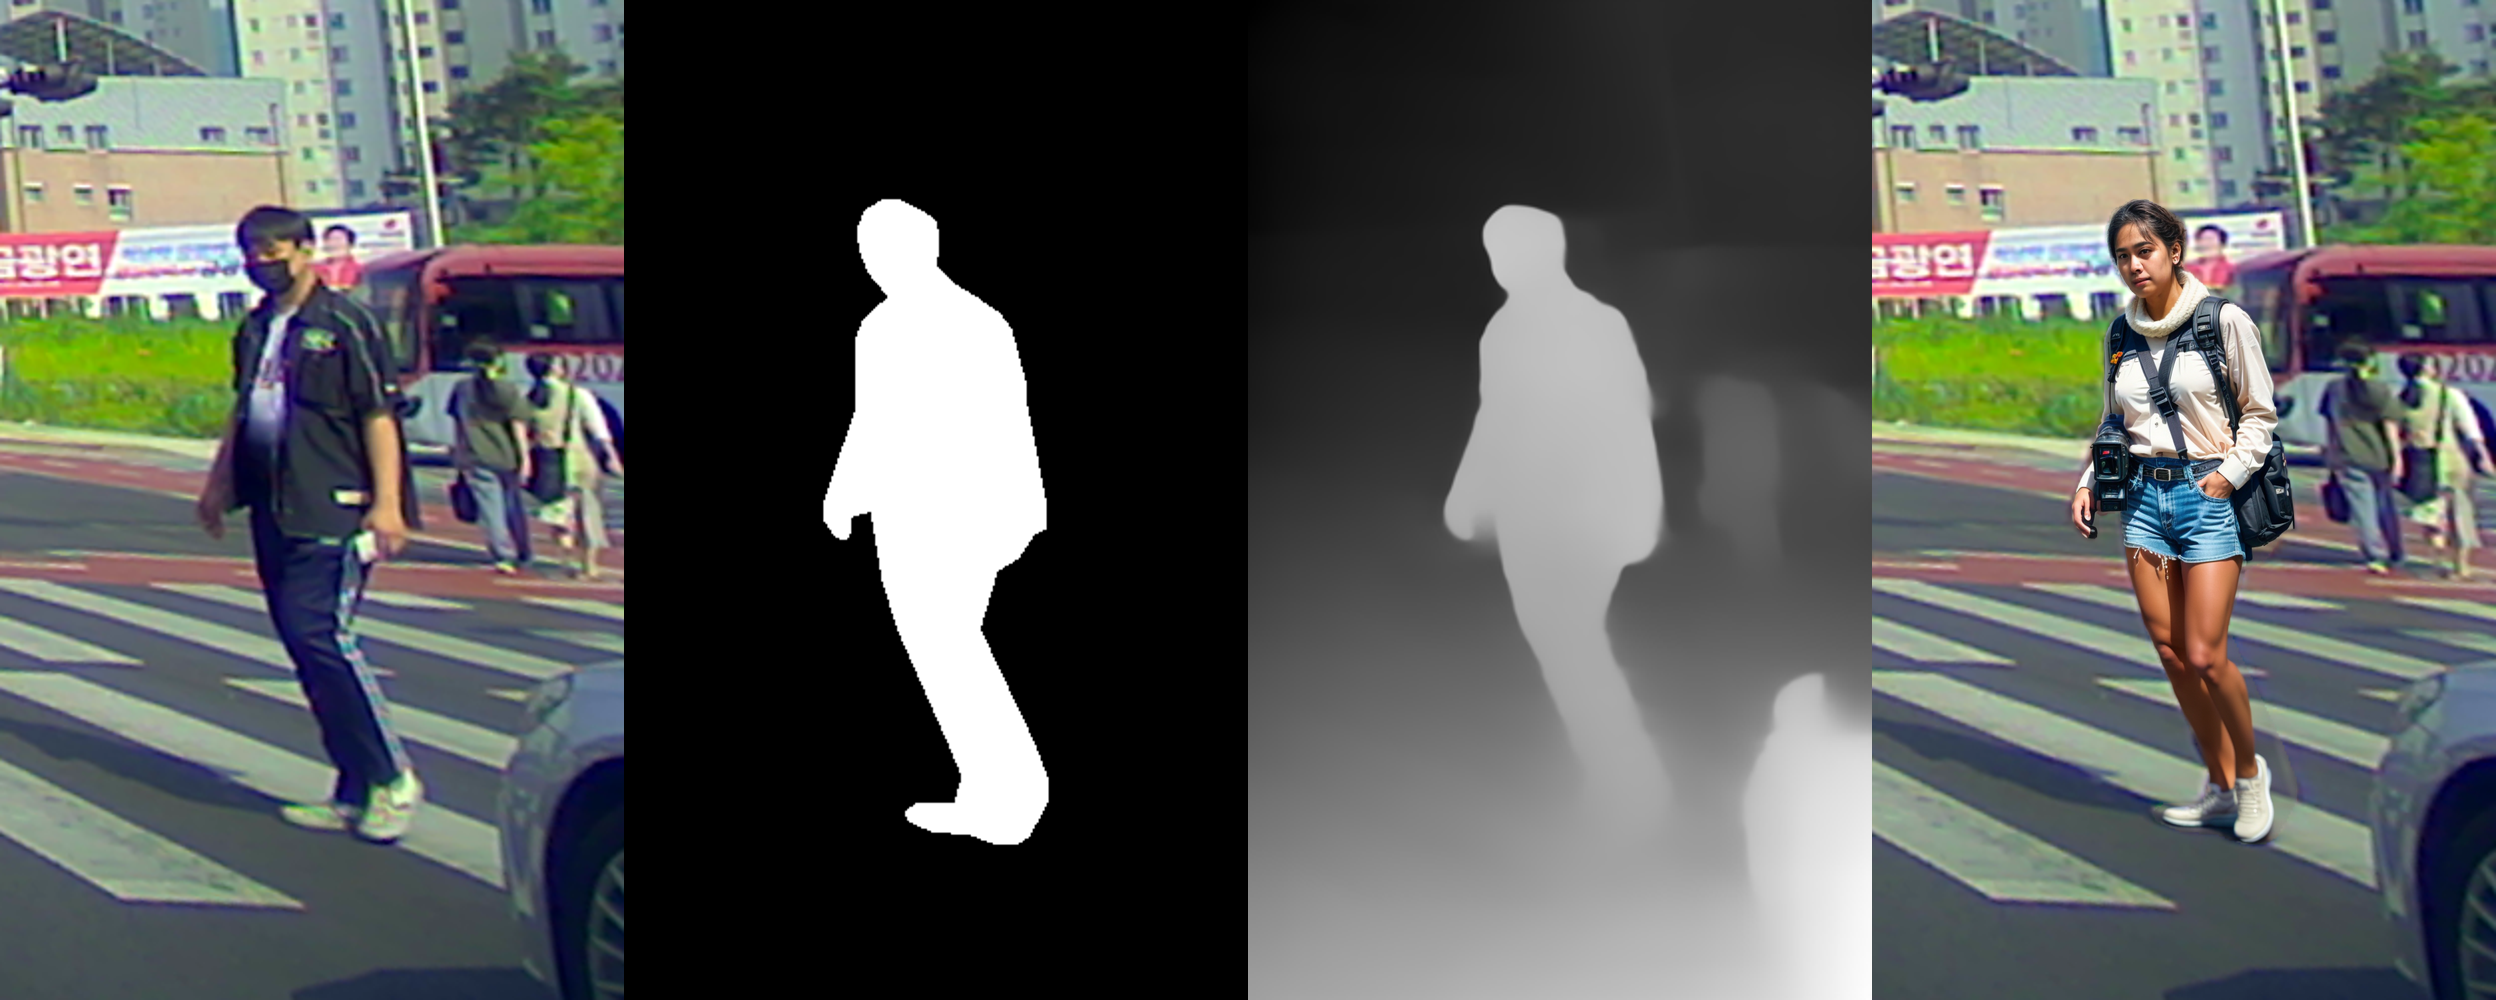

In [67]:
grid = make_grid([image,mask,con_image,result_image], 1, 4)
display(grid)

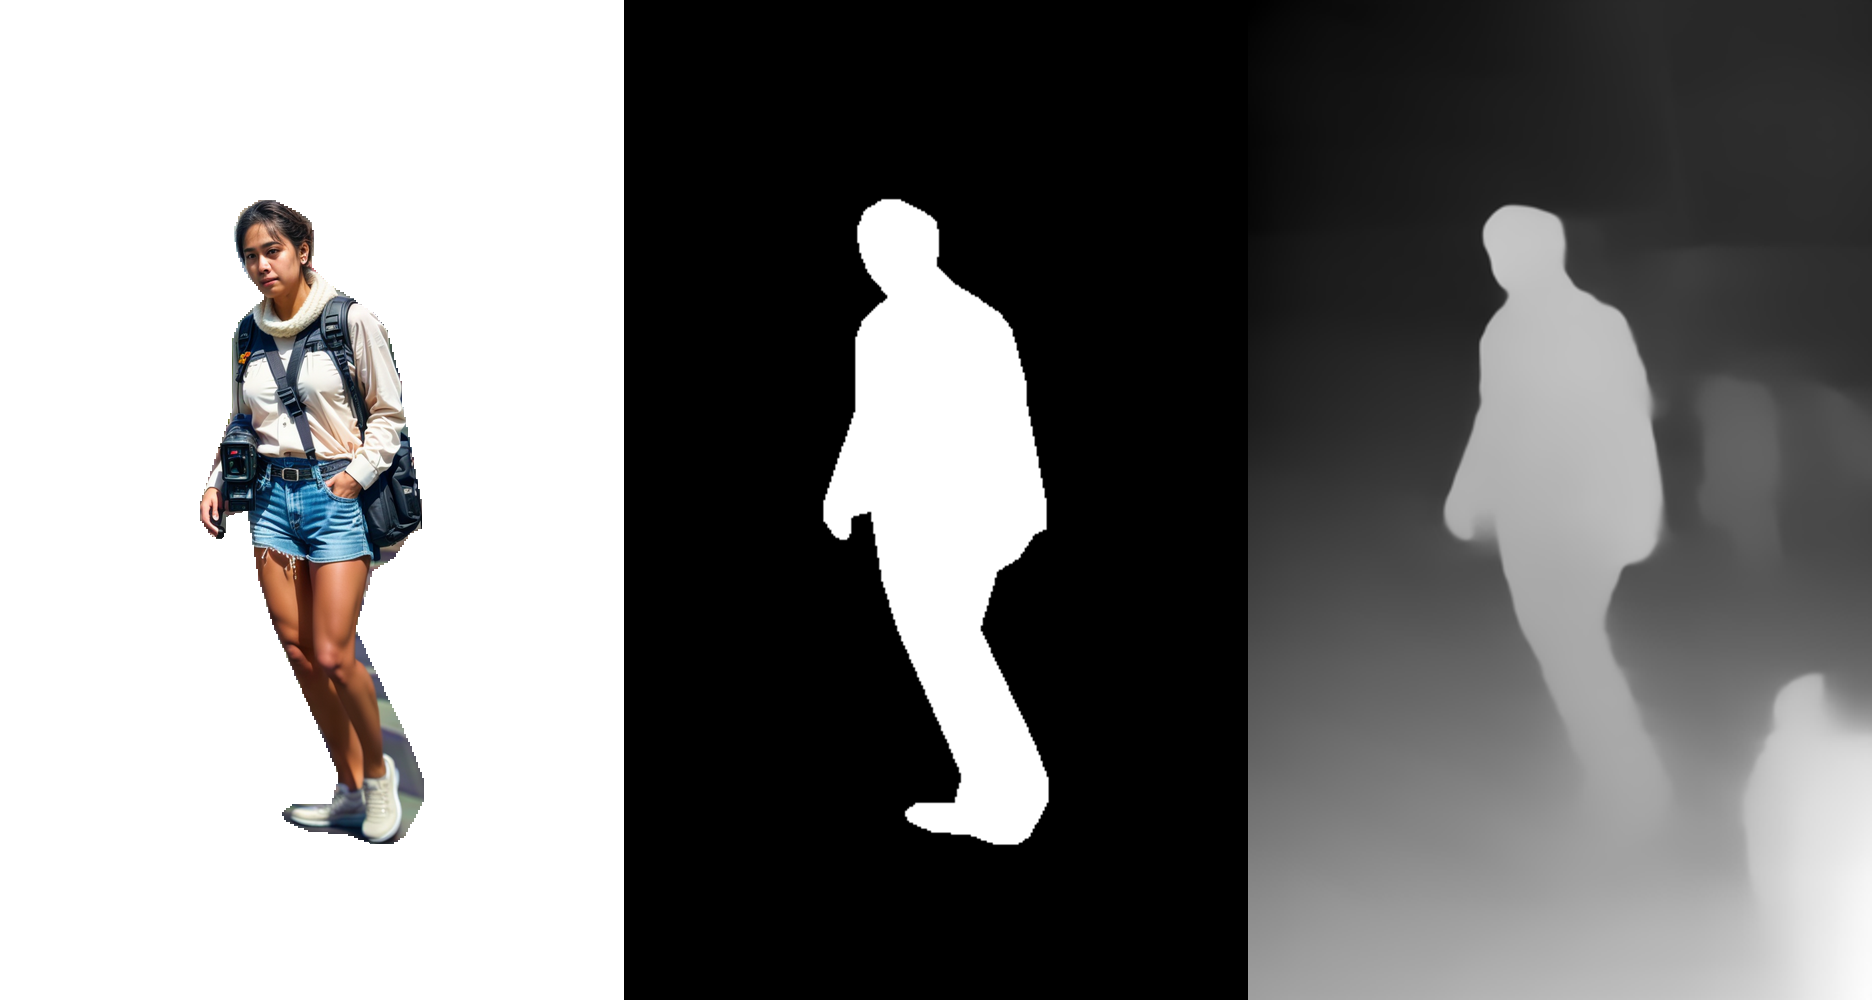

In [70]:
import numpy as np
from PIL import Image
from IPython.display import display

spots = np.argwhere(np.array(mask) == 255)
masked_image = np.ones((mask.height, mask.width, 3))*255
result_image_np = np.array(result_image).astype('uint8')

for spot in spots:
    masked_image[spot[0], spot[1], :] = result_image_np[spot[0], spot[1], :]

masked_image = Image.fromarray(masked_image.astype('uint8'))

grid = make_grid([masked_image, mask, con_image], rows=1, cols=3)
display(grid)

In [2]:
def get_mask(im, matter, threshold=220):
    # Get x_scale_factor & y_scale_factor to resize image
    def get_scale_factor(im_h, im_w, ref_size=512):

        if max(im_h, im_w) < ref_size or min(im_h, im_w) > ref_size:
            if im_w >= im_h:
                im_rh = ref_size
                im_rw = int(im_w / im_h * ref_size)
            elif im_w < im_h:
                im_rw = ref_size
                im_rh = int(im_h / im_w * ref_size)
        else:
            im_rh = im_h
            im_rw = im_w

        im_rw = im_rw - im_rw % 32
        im_rh = im_rh - im_rh % 32

        x_scale_factor = im_rw / im_w
        y_scale_factor = im_rh / im_h

        return x_scale_factor, y_scale_factor
    
    # unify image channels to 3
    if len(im.shape) == 2:
        im = im[:, :, None]
    if im.shape[2] == 1:
        im = np.repeat(im, 3, axis=2)
    elif im.shape[2] == 4:
        im = im[:, :, 0:3]

    # normalize values to scale it between -1 to 1
    im = (im - 127.5) / 127.5

    im_h, im_w, im_c = im.shape
    x, y = get_scale_factor(im_h, im_w)

    # resize image
    im = cv2.resize(im, None, fx=x, fy=y, interpolation=cv2.INTER_AREA)

    # prepare input shape
    im = np.transpose(im)
    im = np.swapaxes(im, 1, 2)
    im = np.expand_dims(im, axis=0).astype('float32')

    # Initialize session and get prediction
    input_name = matter.get_inputs()[0].name
    output_name = matter.get_outputs()[0].name
    session_result = matter.run([output_name], {input_name: im})

    # refine matte
    matte = (np.squeeze(session_result[0]) * 255).astype('uint8')
    matte = cv2.resize(matte, dsize=(im_w, im_h), interpolation=cv2.INTER_AREA)

    # obtain predicted foreground mask
    mask = np.where(matte>127, 255, 0)
    return mask.astype('uint8')

In [3]:
import torch
import onnxruntime
import os
import cv2
from PIL import Image
from tqdm import tqdm
import numpy as np

matter = onnxruntime.InferenceSession('/data/noah/ckpt/pretrain_ckpt/matting/modnet.onnx', None)
image_path = '/data/noah/inference/magna_object/person/images/399_a old person_1.png'
out_path = '/data/noah/399_a old person_1.png'

# for image_name in tqdm(os.listdir(image_path)):
image = Image.open(image_path)
mask = get_mask(np.array(image).astype('uint8'), matter)
check = np.sum(mask)//(image.height * image.width)
Image.fromarray(mask).convert('L').save(out_path)